# Difference in Difference

## Milestone 1

### Step 1

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns

import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("../diff_in_diff.csv")
df.head()

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4


### Step 2

In [3]:
df.dtypes

sales         float64
discount        int64
age             int64
gender         object
cust_state     object
tenure          int64
profit        float64
month           int64
dtype: object

In [4]:
df.isna().mean()

sales         0.0000
discount      0.0000
age           0.0000
gender        0.0993
cust_state    0.0000
tenure        0.0000
profit        0.0000
month         0.0000
dtype: float64

In [5]:
df["is_w"] = np.where(df["gender"] == "W", 1, 0)

### Step 3

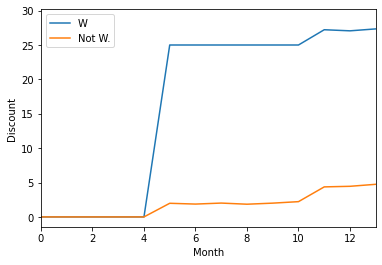

In [6]:
df_plt = df.groupby(["month", "is_w"])["discount"].mean().reset_index()

plt.plot(df_plt.query("is_w==1")["month"], df_plt.query("is_w==1")["discount"], label="W")
plt.plot(df_plt.query("is_w==0")["month"], df_plt.query("is_w==0")["discount"], label="Not W.")
plt.xlim(0, 13)
plt.ylabel("Discount")
plt.xlabel("Month")
plt.legend();

We can see a sharp increase in women's discounts at month five. This does not happen to men.
 
### Step 4


In [7]:
state_df = df.groupby(["month", "cust_state"])[["profit", "discount"]].mean().reset_index()

state_df.head()

,month,cust_state,profit,discount
0,0,AC,42.190000,0.0
1,0,AL,55.047647,0.0
2,0,AM,62.797273,0.0
3,0,AP,63.494000,0.0
4,0,BA,67.307551,0.0


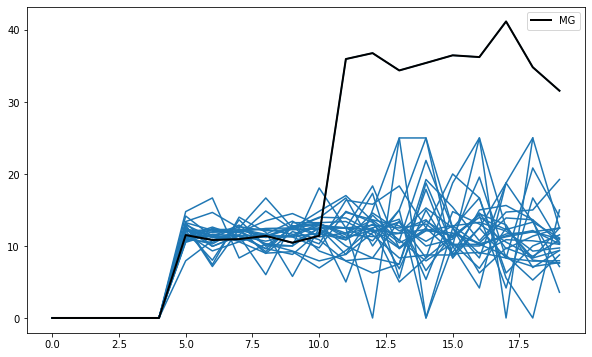

In [8]:
plt.figure(figsize=(10,6))

for state in state_df["cust_state"].unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")["month"],
             state_df.query(f"cust_state == '{state}'")["discount"], c="C0")
    
plt.plot(state_df.query("cust_state == 'MG'")["month"],
         state_df.query("cust_state == 'MG'")["discount"], label="MG", lw=2, color="black")

plt.legend();

We can also see a sharp increase in discount for the state of MG on month 11. 
 
## Milestone 2: Before and After Comparison
 

### Step 1
 
After month 5, the e-commerce company started giving \$25 discounts for women on mother's day. Hence, the post intervention period is after month 5. Also, since only women were contemplated by the mother's day discount, they are the treated group. 

In [9]:
df_diff_in_diff = (df
                   .assign(post_intervention = df["month"] >= 5)
                   .assign(treated = df["is_w"] == 1))

In [10]:
df_diff_in_diff.head()

,sales,discount,age,gender,cust_state,tenure,profit,month,is_w,post_intervention,treated
0,1153.28,0,25,O,MA,19,57.66,7,0,True,False
1,1978.13,0,26,M,MG,16,98.91,6,0,True,False
2,1095.70,0,26,W,RJ,20,54.78,2,1,False,True
3,2404.90,25,30,W,BA,18,95.24,6,1,True,True
4,1704.80,0,38,M,PB,15,85.24,4,0,False,False


### Step 2

In [11]:
treated_after = (df_diff_in_diff
                 .query("treated")
                 .query("post_intervention")
                 ["profit"]
                 .mean())


treated_before = (df_diff_in_diff
                  .query("treated")
                  .query("~post_intervention")
                  ["profit"]
                  .mean())

treated_after - treated_before

7.141746279890299

After the intervention period, the woman's profit increased by \$7.14. In other words
 
$$
E[Y|Gender=W, Period=1] - E[Y|Gender=W, Period=0] = 7.14
$$
 
We can interpret this as the average causal effect of the discount on profit **only if woman's profit is not changing with time**. That is, only if, if there were no discount (potential outcome 0), women's profit before and after the intervention were the same:
 
$$
E[Y_0|Gender=W, Period=1] = E[Y_0|Gender=W, Period=0]
$$ 

 
### Step 3

In [12]:
control_after = (df_diff_in_diff
                 .query("~treated")
                 .query("post_intervention")
                 ["profit"]
                 .mean())

treated_after - control_after

-7.124377132193672

After the intervention period, the treated (woman's) profit is \$7.12 **lower** than the untreated (men) group. That is,
 
$$
E[Y|Gender=W, Period=1] - E[Y|Gender=M, Period=1] = -7.46
$$
 
We can interpret this as the average causal effect of the discount on profit **only if woman's would the same profit as men's if there were no discount for woman**. 
 
$$
E[Y_0|Gender=W, Period=1] = E[Y_0|Gender=M, Period=1]
$$ 


## Milestone 3: Difference in Differences

### Step 1

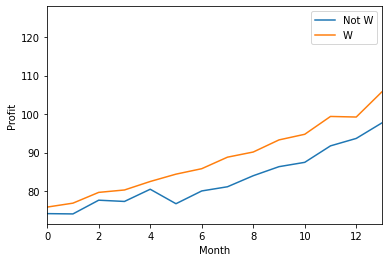

In [13]:
df_plt = df.groupby(["month", "is_w"])["profit"].mean().reset_index()

plt.plot(df_plt.query("is_w==1")["month"], df_plt.query("is_w==1")["profit"], label="Not W")
plt.plot(df_plt.query("is_w==0")["month"], df_plt.query("is_w==0")["profit"], label="W")
plt.xlim(0, 13)
plt.ylabel("Profit")
plt.xlabel("Month")
plt.legend();

Treated and control groups seem to have parallel trends, aside for when the intervention takes place (month 5). However, men's profit is overall higher than women's profit, so the assumption we need to make in step 5 is probably not true. Also, women's profit seems to be increasing over time, so the assumption we had to make in step 4 is also probably not true.
 
 
### Step 2

In [14]:
control_before = (df_diff_in_diff
                  .query("~treated")
                  .query("~post_intervention")
                  ["profit"]
                  .mean())

(treated_after - treated_before) - (control_after - control_before)

-4.7735016421366225

### Step 3

In [15]:
smf.ols('profit ~ treated*post_intervention', data=df_diff_in_diff).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,80.5275,0.342,235.715,0.000,79.858,81.197
treated[T.True],-2.3509,0.532,-4.421,0.000,-3.393,-1.309
post_intervention[T.True],11.9152,0.402,29.673,0.000,11.128,12.702
treated[T.True]:post_intervention[T.True],-4.7735,0.625,-7.642,0.000,-5.998,-3.549


The interaction coefficient is numerically identical to the diff-in-diff estimator we've estimated by hand. This diff-in-diff estimator can be interpreted as the causal effect if men's and women's profit have similar growth trajectories (parallel trends). This is a much weaker assumption than the ones we've made on steps 4 and 5. 
 
That is, if the treatment effect of giving \\$ 25 in discount is -4.77, things are not looking good for the discount product. This means that, for every \\$1.00 in discount, we expect to lose about \\$0.20. 

## Milestone 4: Synthetic Control

### Step 1

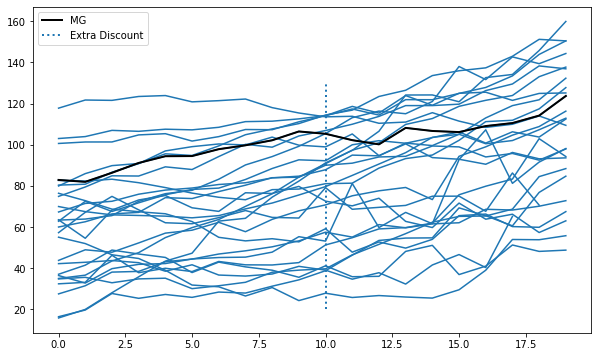

In [16]:
plt.figure(figsize=(10,6))

for state in state_df["cust_state"].unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")["month"],
             state_df.query(f"cust_state == '{state}'")["profit"], c="C0")
    
plt.plot(state_df.query("cust_state == 'MG'")["month"],
         state_df.query("cust_state == 'MG'")["profit"], label="MG", lw=2, color="black")

plt.vlines(x=10, ymin=20, ymax=130, linestyle=":", lw=2, label="Extra Discount")

plt.legend();

Notice that we have many states and multiple time periods. So there isn't a clear control we can compare against the treated state, MG.
 
### Step 2
 
 


In [17]:
inverted = (state_df
            .pivot(index='cust_state', columns="month")["profit"] # make one column per year and one row per state
            .fillna(0)
            .T) # flip the table to have one column per state

inverted_pre = inverted[inverted.index < 11]
inverted_pre.head()

cust_state,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
month,,,,,,,,,,,,,,,,,,,,,
0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,82.661935,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,82.319318,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060937,86.637955,121.561389,83.237867,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,81.540486,...,84.782019,65.616638,72.470250,52.260938,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,79.171152,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353


As we can see, we now have a dataset where the rows are the time periods and the columns are the states. Each value is the average profit for that particular month and state. 
 
## Step 3


In [18]:
from sklearn.linear_model import ElasticNet


y = inverted_pre["MG"].values 
X = inverted_pre.drop(columns="MG").values


model_synth = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000).fit(X, y)

weights = model_synth.coef_

weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15666702, 0.06709938, 0.15451208, 0.14239844, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11871068,
       0.        , 0.08386732, 0.        , 0.11140646, 0.        ,
       0.        , 0.00979641, 0.        , 0.        , 0.13232692,
       0.        ])

Using ElasticNet, we can find weights such that we can build our synthetic control in a way that approximates the treated unit, MG, in the pre-intervention period.
 
$$
Profit_{mg} \approx \sum^S_{s=0} w_s * Profit_s
$$
 
We can even see which states we are combining to make our synthetic control. For instance we are only using states CE, DF, ES, ES, GO, PE, PR, RN, RS and SP in the combination. All other weights are zero.


In [19]:
pd.DataFrame(dict(state=inverted.drop(columns="MG").columns, weights=weights))

,state,weights
0,AC,0.000000
1,AL,0.000000
2,AM,0.000000
3,AP,0.000000
4,BA,0.000000
5,CE,0.156667
6,DF,0.067099
7,ES,0.154512
8,GO,0.142398
9,MA,0.000000


### Step 4

In [20]:
synth = inverted.drop(columns=["MG"]).fillna(0).values.dot(weights)

synth

array([ 82.03056215,  84.54879919,  87.689239  ,  90.43252607,
        93.76770244,  93.43824919,  97.0876573 , 100.1759432 ,
       101.71088524, 103.36191277, 105.74886091, 109.68786782,
       109.17020599, 114.17917446, 115.04636528, 117.5955818 ,
       118.11083301, 121.99262304, 126.39896116, 128.03030073])

### Step 5

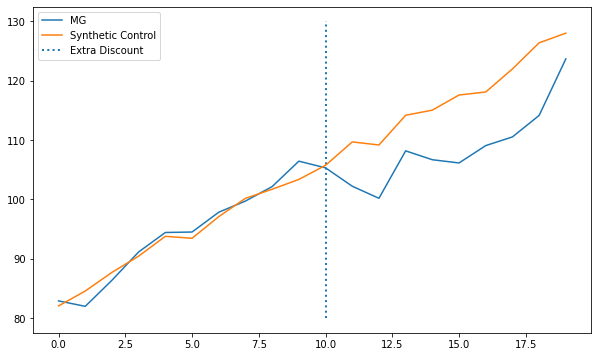

In [21]:
plt.figure(figsize=(10,6))
plt.plot(state_df.query(f"cust_state == 'MG'")["month"], state_df.query(f"cust_state == 'MG'")["profit"], label="MG")
plt.plot(state_df.query(f"cust_state == 'MG'")["month"], synth, label="Synthetic Control")
plt.vlines(x=10, ymin=80, ymax=130, linestyle=":", lw=2, label="Extra Discount")

plt.legend();

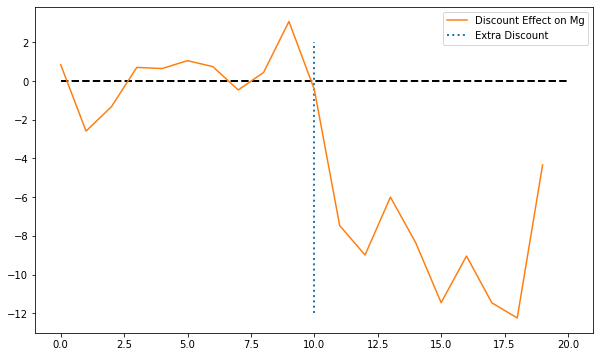

In [22]:
plt.figure(figsize=(10,6))
plt.plot(state_df.query(f"cust_state == 'MG'")["month"],
         state_df.query(f"cust_state == 'MG'")["profit"] - synth, label="Discount Effect on Mg",
         c="C1"
        )

plt.vlines(x=10, ymin=-12, ymax=2, linestyle=":", lw=2, label="Extra Discount")
plt.hlines(y=0, xmin=0, xmax=20, linestyle="--", lw=2, color="black")

plt.legend();

We can see that the profit of synthetic control keeps growing after the intervention, while the profit for the state of MG takes a dip. This means that, after increasing the discount, the state became less profitable.
 
If we plot the difference between them, we can see the effect of discounts on profits over time. Again, we conclude that the effect is negative, meaning that discount is not profitable.